In [661]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot, add_constant
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# matplotlib.rc("font", family = "NanumGothic")
# matplotlib.rc("axes", unicode_minus = False)

In [662]:
df_raw = pd.read_csv("C:/Users/PIAI/csv_file/Car.csv", encoding = 'euc-kr')
df_raw.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN


In [663]:
print("Raw Data :" ,df_raw.shape)

Raw Data : (7253, 13)


## step 1. Data Processing

#### - 단위와 같이 포현되어 있는 수치형 변수 처리

In [664]:
df_raw['Mileage'] = df_raw['Mileage'].str.replace('kmpl', '')
df_raw['Engine'] = df_raw['Engine'].str.replace('CC', '')
df_raw['Power'] = df_raw['Power'].str.replace('bhp', '')

In [665]:
df_raw['Mileage'] = df_raw['Mileage'].str.replace('null', '0')
df_raw['Engine'] = df_raw['Engine'].str.replace('null', '0')
df_raw['Power'] = df_raw['Power'].str.replace('null', '0')

In [666]:
df_raw.drop(columns = ["New_Price"], inplace = True)

New Price는 신차 모델의 가격으로, 중고차 가격 예측에 상관이 없을 것 같아서 삭제함.

#### - Data Type  확인 및 변경

In [667]:
df_raw.dtypes

Name                  object
Location              object
Price                float64
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
dtype: object

In [668]:
# object data type을 category data type 으로 변경
df_raw['Fuel_Type'] = df_raw['Fuel_Type'].astype('category')
df_raw['Transmission'] = df_raw['Transmission'].astype('category')
df_raw['Owner_Type'] = df_raw['Owner_Type'].astype('category')

In [669]:
# object data tyoe을 float data type 으로 변경
df_raw['Mileage'] = df_raw['Mileage'].astype('float')
df_raw['Engine'] = df_raw['Engine'].astype('float')
df_raw['Power'] = df_raw['Power'].astype('float')

In [670]:
# data type 재확인
df_raw.dtypes

Name                   object
Location               object
Price                 float64
Year                    int64
Kilometers_Driven       int64
Fuel_Type            category
Transmission         category
Owner_Type           category
Mileage               float64
Engine                float64
Power                 float64
Seats                 float64
dtype: object

#### - 결측치 확인 및 처리

In [671]:
df_raw.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
dtype: int64

In [672]:
# data가 0인 data 처리
df_raw.loc[df_raw.Mileage == 0, 'Mileage'] = np.nan
df_raw.loc[df_raw.Engine == 0, 'Engine'] = np.nan
df_raw.loc[df_raw.Power == 0, 'Power'] = np.nan

In [673]:
df_raw['Mileage'] = df_raw['Mileage'].fillna(df_raw['Mileage'].mean())
df_raw['Engine'] = df_raw['Engine'].fillna(df_raw['Engine'].mean())
df_raw['Power'] = df_raw['Power'].fillna(df_raw['Power'].mean())
df_raw['Seats'] = df_raw['Seats'].fillna(df_raw['Seats'].mean())

연속형 변수 결측치 평균값으로 대체 처리

In [674]:
df_raw.dropna(inplace = True)

In [675]:
# Check Name column uniques
df_raw['Name'].nunique()

1921

Name 변수의 결측지를 처리했음에도 데이터의 양은 5000개 이상이다.  
고유치 확인 결과 1921개로, 각 고유치가 가질 수 있는 데이터의 양은  
2 ~ 3개이다. 이 데이터를 가지고 분석을 진행한다면 유의미한 결과를  
낼 수 없다고 생각했다. 따라서 Name을 삭제하기로 결정.  

Location 변수도 상관이 없다고 판단하여 삭제시킴.

In [676]:
df_raw.isnull().sum()

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
dtype: int64

In [677]:
df_raw.drop(columns=['Name'], inplace = True)
df_raw.drop(columns=['Location'], inplace = True)

In [678]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6200 entries, 0 to 7236
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Price              6200 non-null   float64 
 1   Year               6200 non-null   int64   
 2   Kilometers_Driven  6200 non-null   int64   
 3   Fuel_Type          6200 non-null   category
 4   Transmission       6200 non-null   category
 5   Owner_Type         6200 non-null   category
 6   Mileage            6200 non-null   float64 
 7   Engine             6200 non-null   float64 
 8   Power              6200 non-null   float64 
 9   Seats              6200 non-null   float64 
dtypes: category(3), float64(5), int64(2)
memory usage: 406.2 KB


In [679]:
# df_raw['Price'] = df_raw['Price'].fillna(df_raw['Price'].median())

In [680]:
df_raw.isnull().sum()

Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
dtype: int64

#### - 이상치 제거

In [681]:
df_raw.describe()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
count,6200.000000,6200.000000,6.200000e+03,6200.000000,6200.000000,6200.000000,6200.000000
mean,14912.514750,2013.434194,5.815738e+04,18.384720,1619.983814,113.300417,5.278508
std,17674.318464,3.271969,9.010627e+04,4.156986,599.744181,53.540989,0.805628
min,7.080000,1998.000000,1.710000e+02,6.400000,72.000000,34.200000,0.000000
25%,5365.360000,2012.000000,3.300000e+04,15.400000,1198.000000,77.750000,5.000000
50%,8814.520000,2014.000000,5.251450e+04,18.346527,1493.000000,98.600000,5.000000
75%,15869.972500,2016.000000,7.227750e+04,21.100000,1968.000000,138.030000,5.000000
max,245273.600000,2019.000000,6.500000e+06,33.540000,5998.000000,616.000000,10.000000


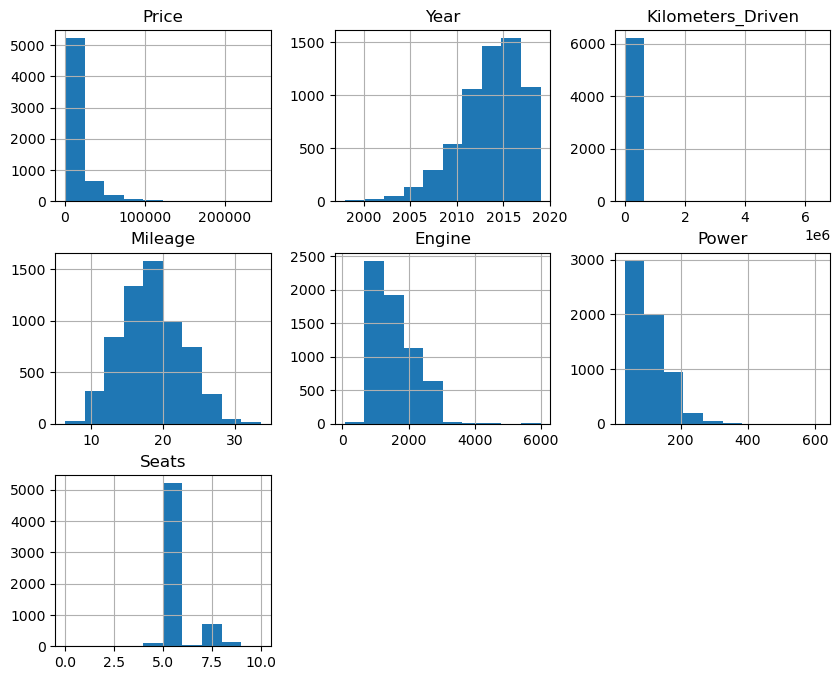

In [682]:
df_raw.hist(figsize = (10, 8))
plt.show()

- Price 는 2.45억원으로 중고차로는 너무 높으며, 특이치로 보임

- Mileage는 거의 정상적으로 분포를 보임

- Engine 은 오른쪽으로 치우져 있음

- Price, Power는 왼쪽으로 치우쳐져 있음

<Axes: >

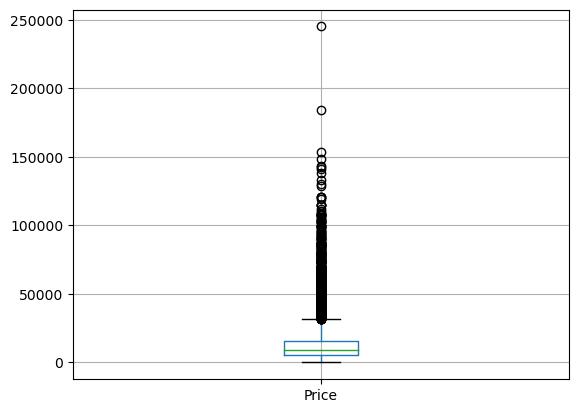

In [683]:
# Price 분포 확인
df_raw.boxplot('Price')

- price 이상치 존재 : 박스플롯을 그려보니 약 1.8억 이상일 때 이상치가 있다고 판단하여 price가 1.8억 이상인 데이터를 제외 시켰다.

In [684]:
# Price 가 1.75억원 이상이면 제외 (중고차로는 너무 비싸다)
df_raw = df_raw[df_raw['Price'] < 175000]
df_raw.reset_index(drop=True, inplace=True)
df_raw.head(3)

,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0
1,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0
2,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0


<Axes: >

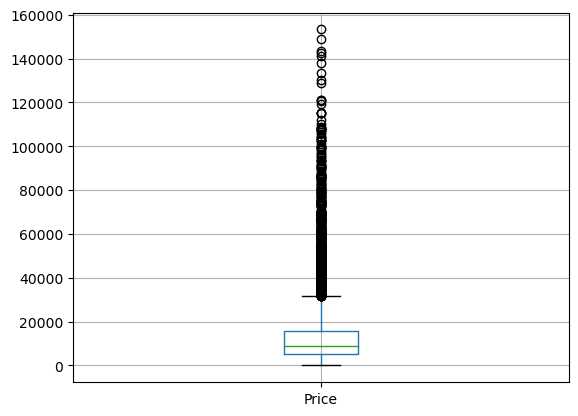

In [685]:
df_raw.boxplot('Price')

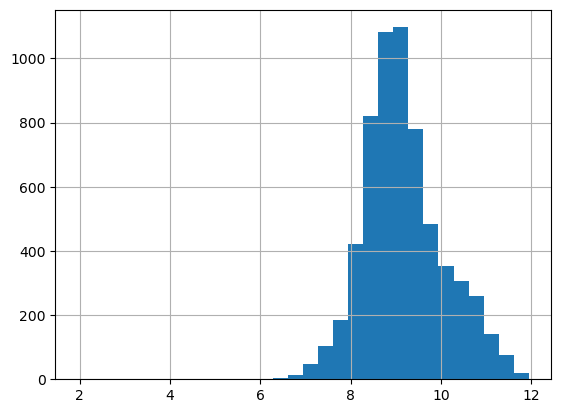

In [686]:
df_raw['Price'] = np.log(df_raw['Price'])
df_raw['Price'].hist(bins = 30)
plt.show()

- Price가 왼쪽으로 기울어져 있음

샤피로 윌크 방법은 일반적으로 데이터의 양이 적은 샘플에 적합한 검정 방법이다.  

큰 샘플 크기의 경우 다른 정규성 검정 방법을 고려하는 것이 좋다.  
따라서 Anderson 방법으로 검정을 실행했다.

In [687]:
# 정규성 검정 : Anderson
df_norm=stats.anderson(df_raw['Price'], dist='norm')
print(df_norm)

AndersonResult(statistic=42.48217946060868, critical_values=array([0.576, 0.656, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=9.178241601732568, scale=0.8837743480270074)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


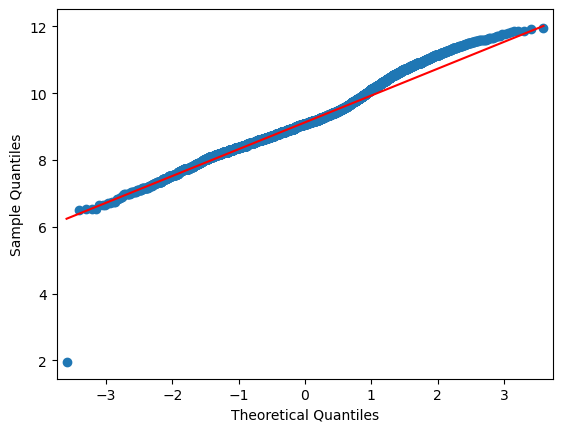

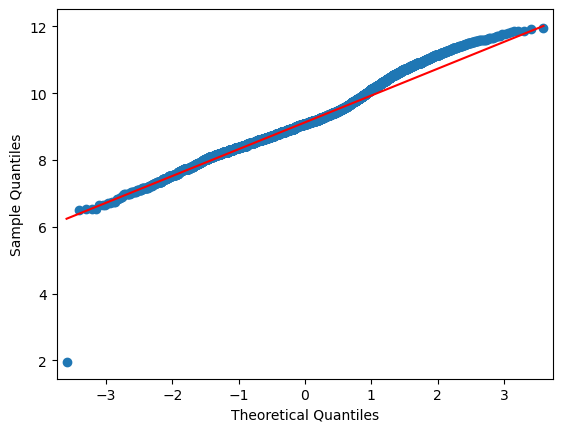

In [688]:
# 잔차 정규성 검정 : QQplot, s-standardized line
# r-regressionline, q-quartiles
qqplot(df_raw['Price'], line = 'q')

Price 정규성 만족

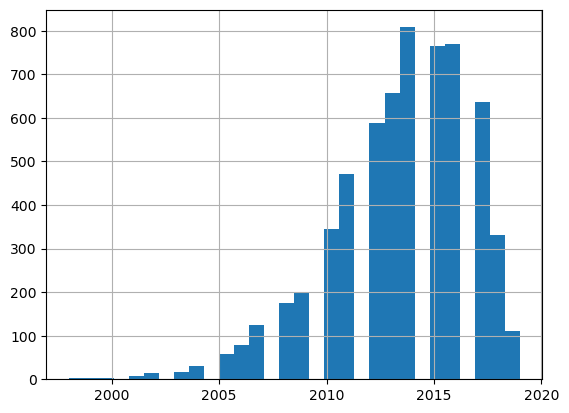

In [689]:
# 설명변수 중 이상치 확인 및 처리

# year 분포 확인
df_raw['Year'].hist(bins=30)
plt.show()

<Axes: >

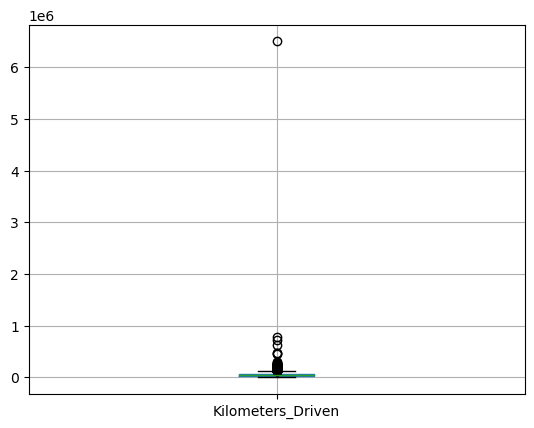

In [690]:
# kilometers_Driven 분포 확인
df_raw.boxplot('Kilometers_Driven')

 Kilometers_Driven 이상치 존재

<Axes: >

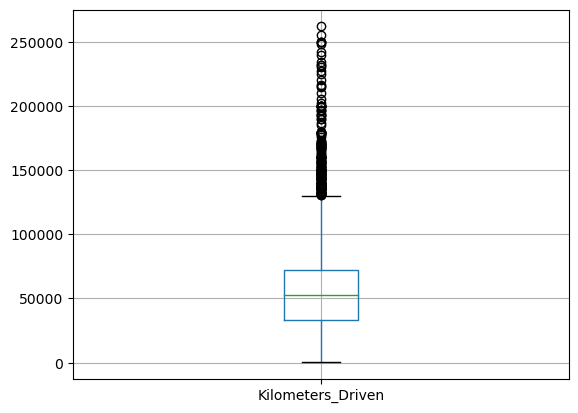

In [691]:
df_raw = df_raw[df_raw['Kilometers_Driven'] < 270000]
df_raw.reset_index(drop=True, inplace=True)
df_raw.boxplot("Kilometers_Driven")

이상치를 제거하기 위해 270000Km 이상의 데이터를 삭제했다.

<Axes: xlabel='Kilometers_Driven', ylabel='Count'>

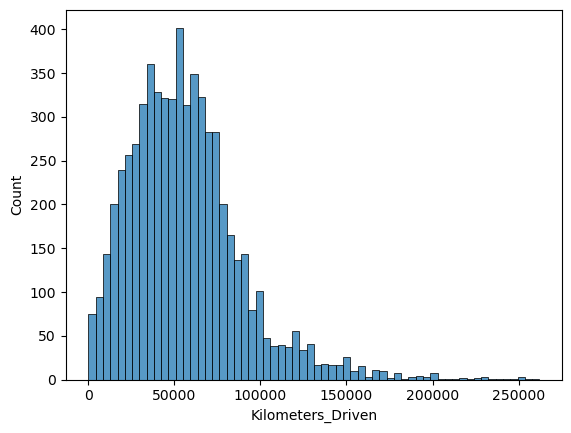

In [692]:
# Kilometers_Driven 분포 확인
sns.histplot(df_raw, x = "Kilometers_Driven")

<Axes: xlabel='Mileage', ylabel='Count'>

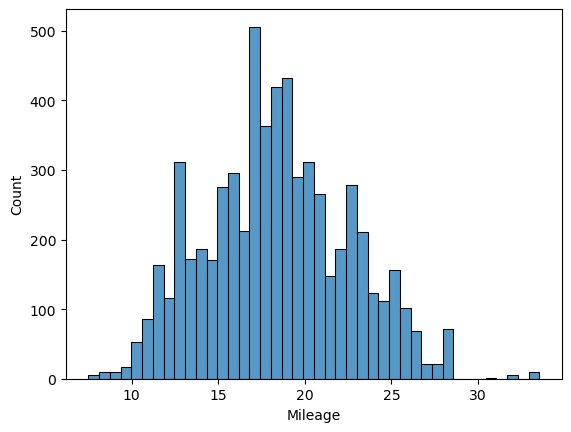

In [693]:
# Mileage 분포 확인
sns.histplot(df_raw, x = "Mileage")

<Axes: xlabel='Engine', ylabel='Count'>

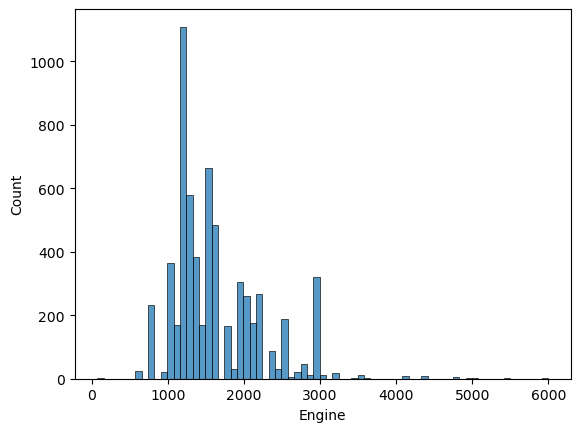

In [694]:
# Engine 성능 분포 확인
sns.histplot(df_raw, x = "Engine")

<Axes: xlabel='Power', ylabel='Count'>

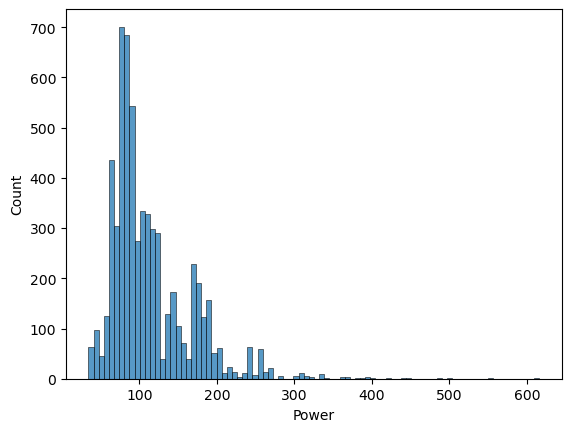

In [695]:
# Power 성능 분포 확인
sns.histplot(df_raw, x = "Power")

=> Power에 이상치 존재

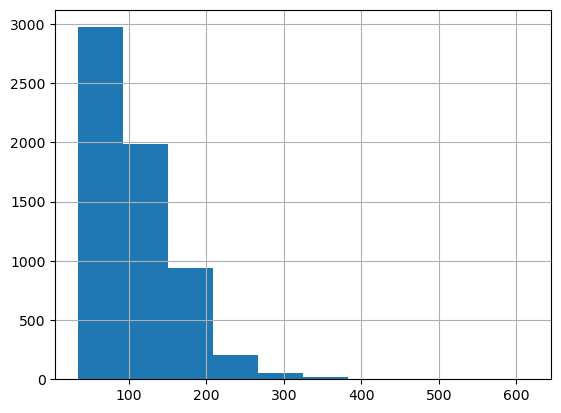

In [696]:
df_raw['Power'].hist()
plt.show()

<Axes: >

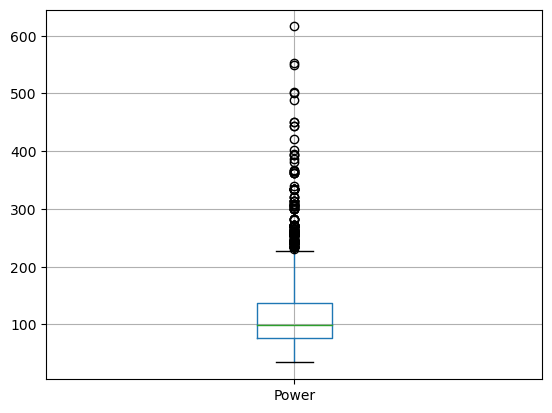

In [697]:
df_raw.boxplot('Power')

power 변수의 600 이상의 값들은 이상치라고 판단하여 삭제시켰다.

<Axes: >

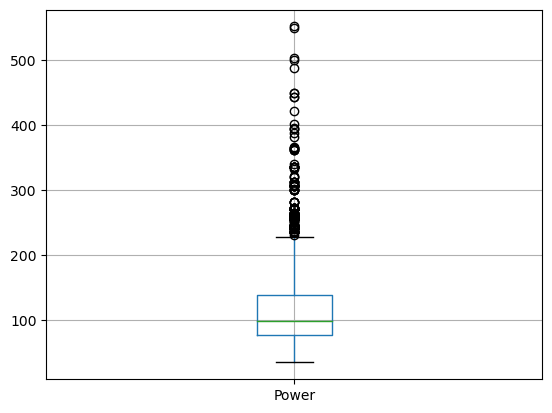

In [698]:
df_raw = df_raw[df_raw['Power'] < 600]
df_raw.reset_index(drop=True, inplace=True)
df_raw.boxplot('Power')

<Axes: >

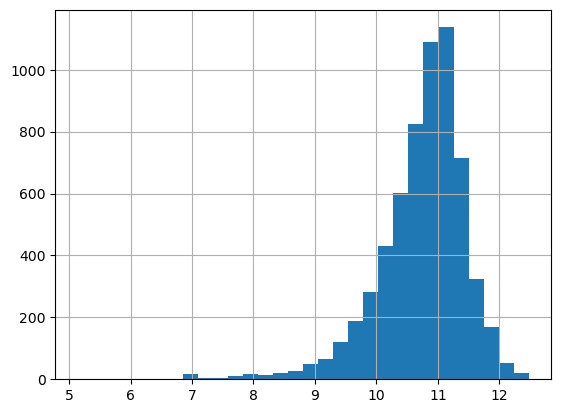

In [699]:
df_raw['Kilometers_Driven'] = np.log(df_raw['Kilometers_Driven'])
df_raw['Kilometers_Driven'].hist(bins = 30) 

<Axes: >

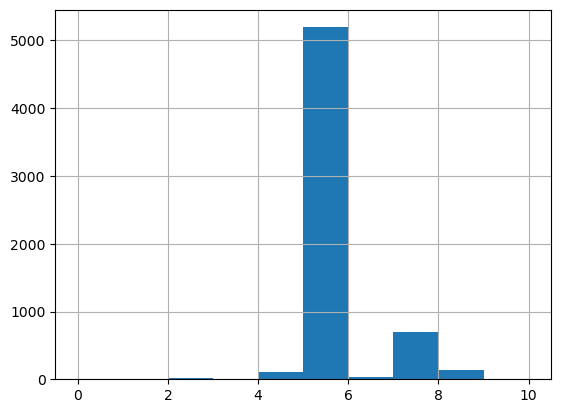

In [700]:
# Seats 분포 확인
df_raw['Seats'].hist()

In [701]:
df_raw["Fuel_Type"].value_counts()

Diesel      3294
Petrol      2824
CNG           57
LPG           10
Electric       2
Name: Fuel_Type, dtype: int64

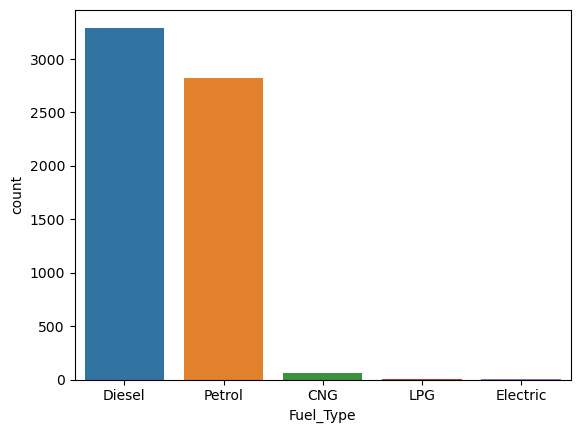

In [702]:
sns.countplot(x="Fuel_Type", data = df_raw, order = df_raw["Fuel_Type"].value_counts().index)
plt.show()

범주형 변수 빈도 확인.

In [703]:
df_raw["Transmission"].value_counts()

Manual       4409
Automatic    1778
Name: Transmission, dtype: int64

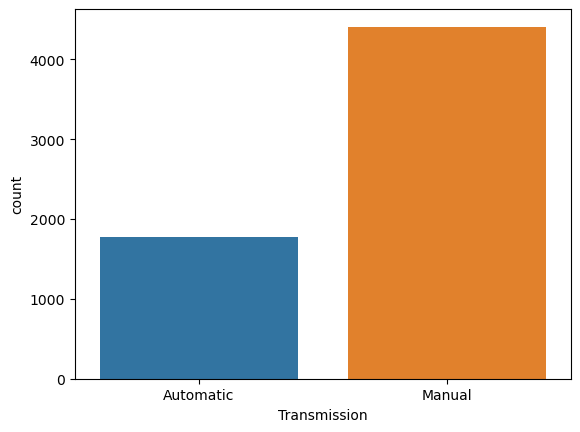

In [704]:
sns.countplot(x="Transmission", data = df_raw)
plt.show()

In [705]:
df_raw["Owner_Type"].value_counts()

First             5084
Second             982
Third              112
Fourth & Above       9
Name: Owner_Type, dtype: int64

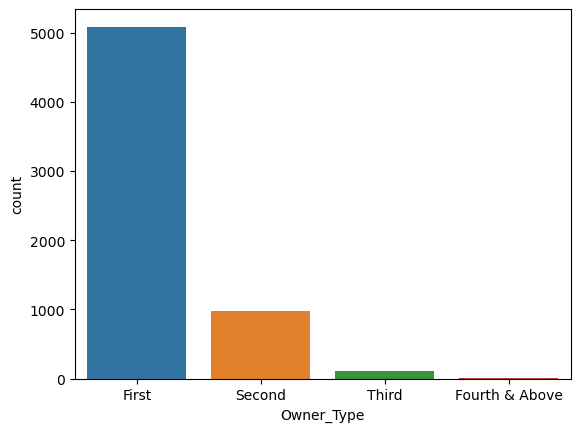

In [706]:
sns.countplot(x="Owner_Type", data = df_raw, order = df_raw["Owner_Type"].value_counts().index)
plt.show()

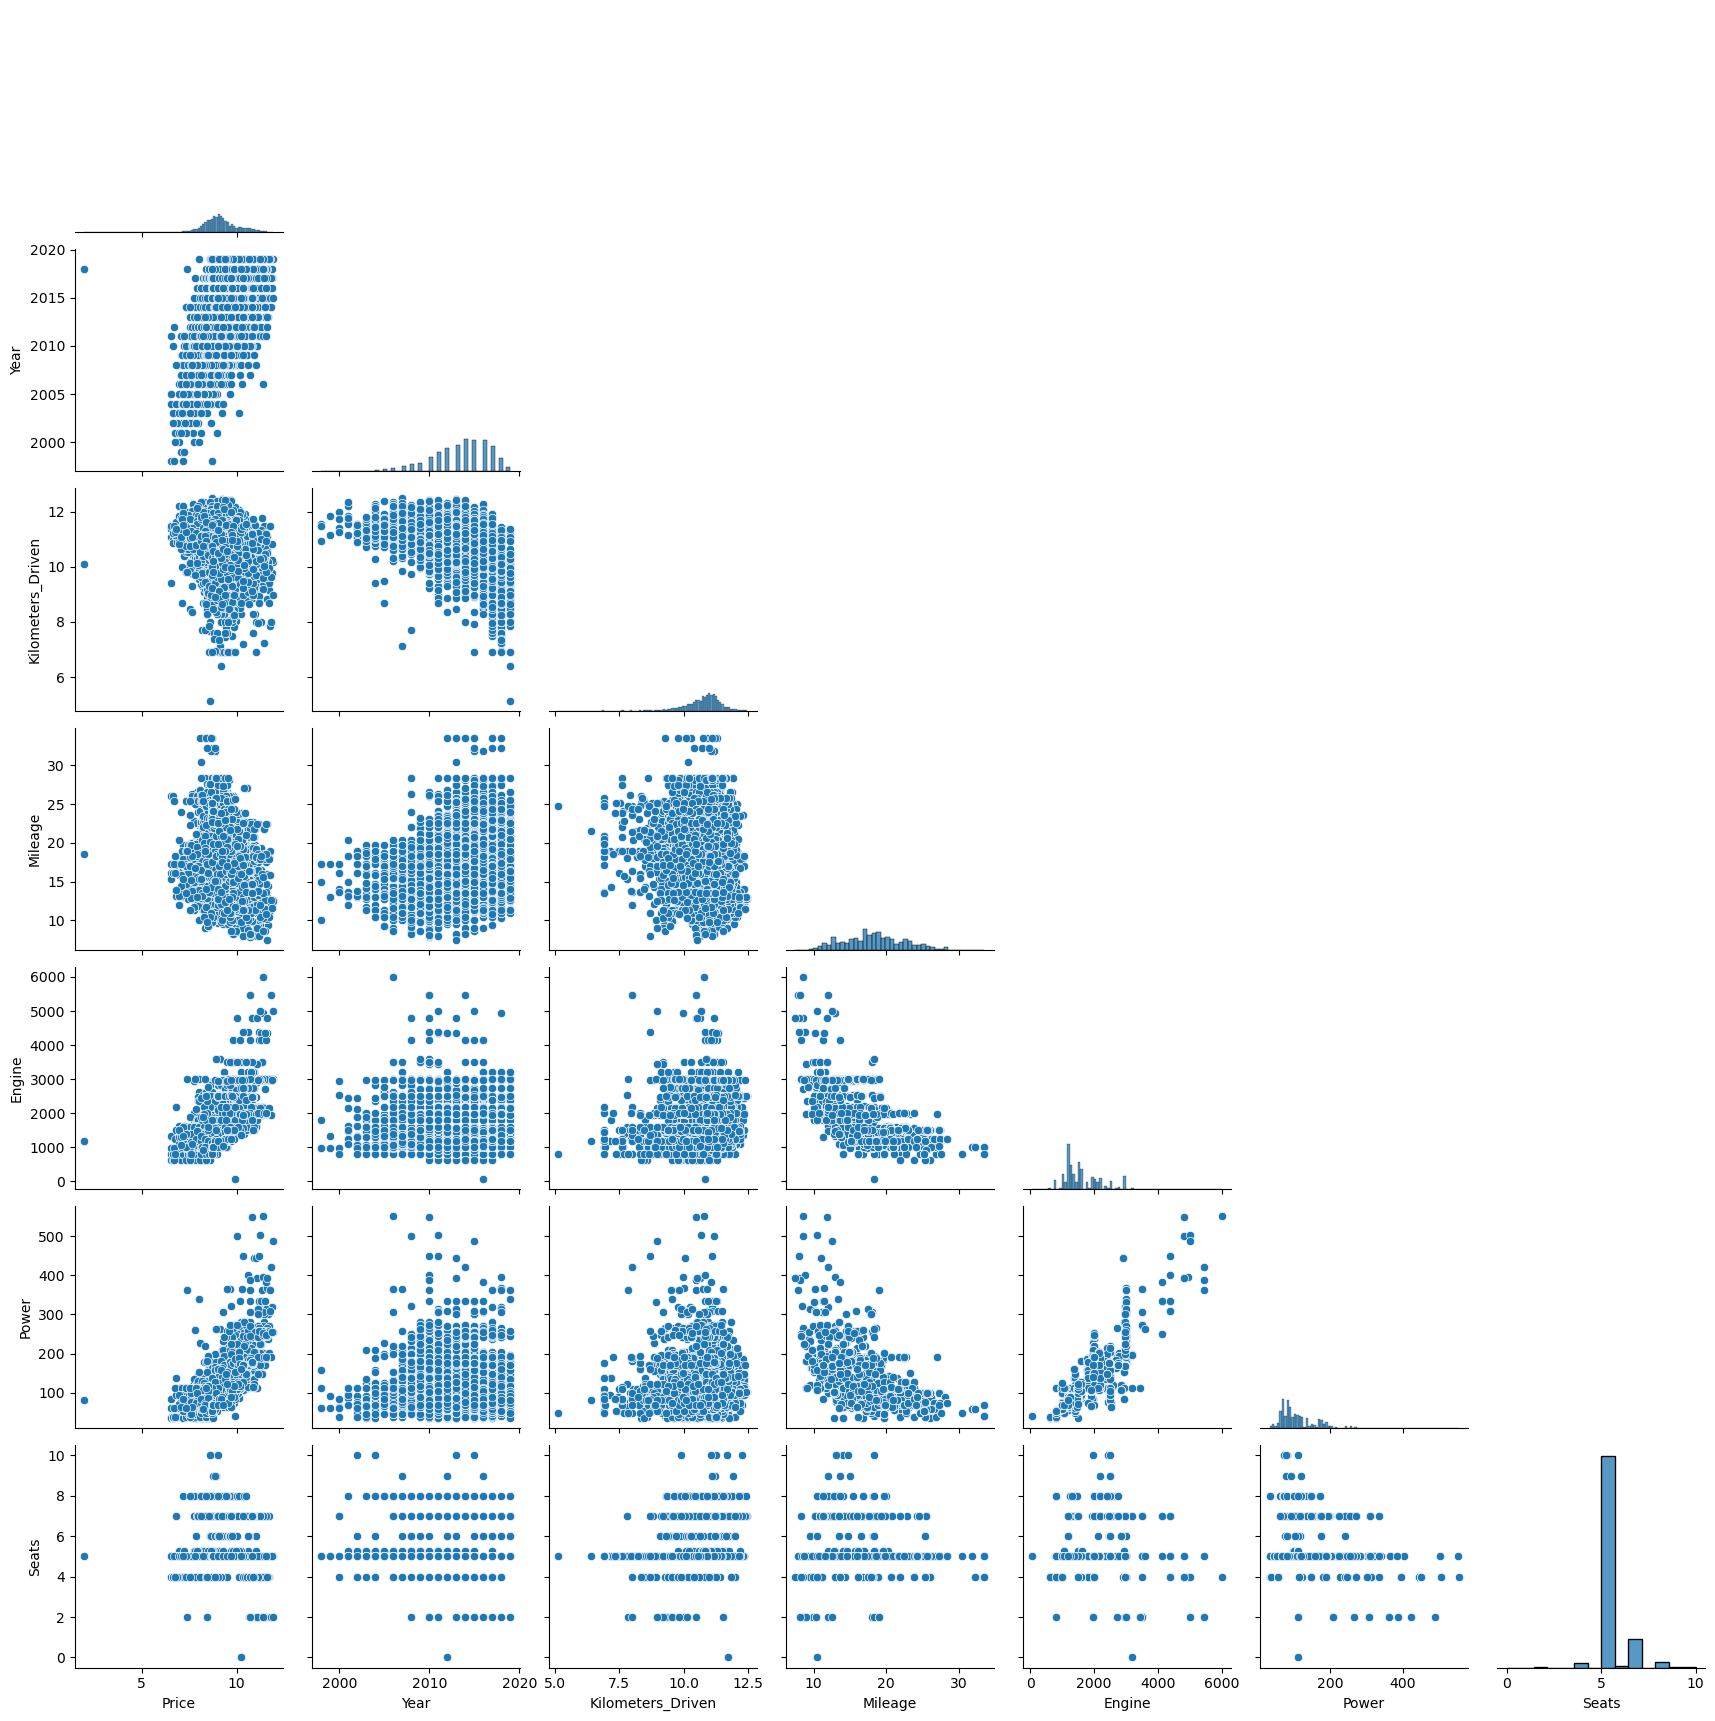

In [707]:
sns.pairplot(data = df_raw, corner = True)
plt.show()

In [708]:
df_raw.corr()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
Price,1.000000,0.499565,-0.204496,-0.290687,0.669789,0.738806,0.166595
Year,0.499565,1.000000,-0.508906,0.291449,-0.053383,0.013646,0.011820
Kilometers_Driven,-0.204496,-0.508906,1.000000,-0.135685,0.152334,0.019064,0.189911
Mileage,-0.290687,0.291449,-0.135685,1.000000,-0.640450,-0.548609,-0.347442
Engine,0.669789,-0.053383,0.152334,-0.640450,1.000000,0.856490,0.400377
Power,0.738806,0.013646,0.019064,-0.548609,0.856490,1.000000,0.105801
Seats,0.166595,0.011820,0.189911,-0.347442,0.400377,0.105801,1.000000


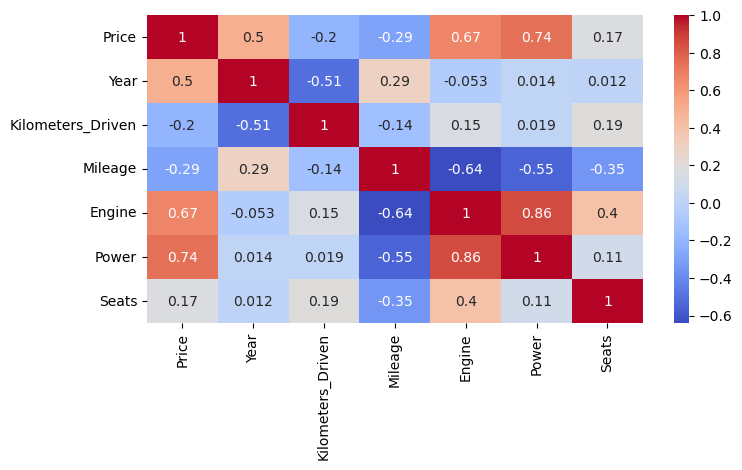

In [709]:
plt.figure(figsize = (8,4))
sns.heatmap(df_raw.corr(),annot= True, cmap= "coolwarm")
plt.show()

* 범주형 변수와 목표변수의 상관관계 확인

In [710]:
dummy_df = pd.get_dummies(df_raw['Transmission'], prefix='Transmission')
df_with_dummies = pd.concat([df_raw['Price'], dummy_df], axis=1)
print(df_with_dummies.corr())

                           Price  Transmission_Automatic  Transmission_Manual
Price                   1.000000                0.609207            -0.609207
Transmission_Automatic  0.609207                1.000000            -1.000000
Transmission_Manual    -0.609207               -1.000000             1.000000


In [711]:
dummy_df = pd.get_dummies(df_raw['Fuel_Type'], prefix='Fuel_Type')
df_with_dummies = pd.concat([df_raw['Price'], dummy_df], axis=1)
print(df_with_dummies.corr())

                       Price  Fuel_Type_CNG  Fuel_Type_Diesel  \
Price               1.000000      -0.071034          0.430236   
Fuel_Type_CNG      -0.071034       1.000000         -0.102895   
Fuel_Type_Diesel    0.430236      -0.102895          1.000000   
Fuel_Type_Electric  0.014486      -0.001734         -0.019188   
Fuel_Type_LPG      -0.044035      -0.003880         -0.042934   
Fuel_Type_Petrol   -0.414316      -0.088364         -0.977815   

                    Fuel_Type_Electric  Fuel_Type_LPG  Fuel_Type_Petrol  
Price                         0.014486      -0.044035         -0.414316  
Fuel_Type_CNG                -0.001734      -0.003880         -0.088364  
Fuel_Type_Diesel             -0.019188      -0.042934         -0.977815  
Fuel_Type_Electric            1.000000      -0.000724         -0.016478  
Fuel_Type_LPG                -0.000724       1.000000         -0.036871  
Fuel_Type_Petrol             -0.016478      -0.036871          1.000000  


In [712]:
dummy_df = pd.get_dummies(df_raw['Owner_Type'], prefix='Owner_Type')
df_with_dummies = pd.concat([df_raw['Price'], dummy_df], axis=1)
print(df_with_dummies.corr())

                              Price  Owner_Type_First  \
Price                      1.000000          0.184337   
Owner_Type_First           0.184337          1.000000   
Owner_Type_Fourth & Above -0.031241         -0.081943   
Owner_Type_Second         -0.139797         -0.932525   
Owner_Type_Third          -0.137108         -0.291508   

                           Owner_Type_Fourth & Above  Owner_Type_Second  \
Price                                      -0.031241          -0.139797   
Owner_Type_First                           -0.081943          -0.932525   
Owner_Type_Fourth & Above                   1.000000          -0.016578   
Owner_Type_Second                          -0.016578           1.000000   
Owner_Type_Third                           -0.005182          -0.058977   

                           Owner_Type_Third  
Price                             -0.137108  
Owner_Type_First                  -0.291508  
Owner_Type_Fourth & Above         -0.005182  
Owner_Type_Second     

목표변수 price와 설명 변수들의 상관관계 분석 결과 Year, Power, Engine, Trainsmission의 상관계수가 높게나와 이 변수들을  
분석 해보기로 하였다.

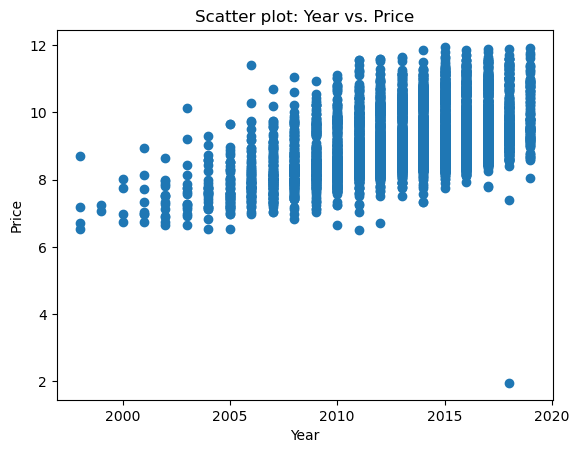

In [715]:
# Year 변수와 price의 산점도
plt.scatter(df_raw['Year'], df_raw['Price'])
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Scatter plot: Year vs. Price')
plt.show()

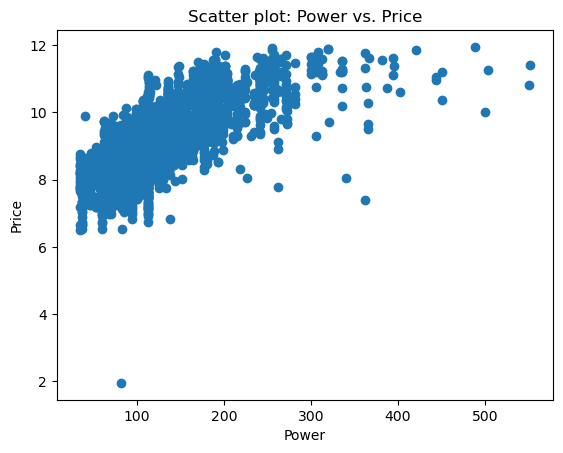

In [716]:
# Power 변수와 price의 산점도
plt.scatter(df_raw['Power'], df_raw['Price'])
plt.xlabel('Power')
plt.ylabel('Price')
plt.title('Scatter plot: Power vs. Price')
plt.show()

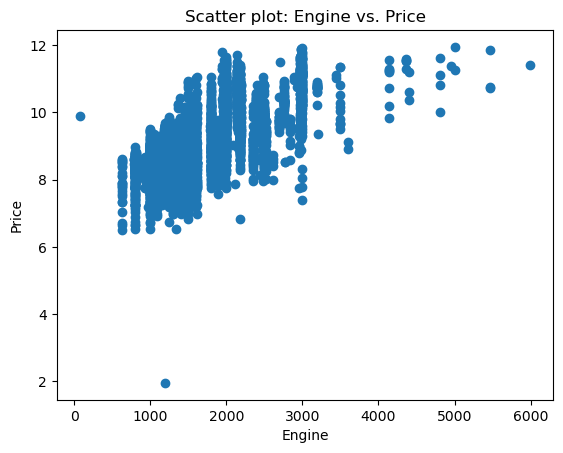

In [718]:
# Engine 변수와 price의 산점도
plt.scatter(df_raw['Engine'], df_raw['Price'])
plt.xlabel('Engine')
plt.ylabel('Price')
plt.title('Scatter plot: Engine vs. Price')
plt.show()

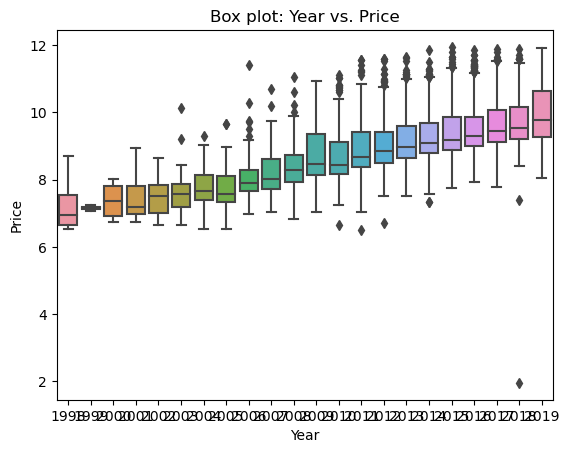

In [720]:
# Year 변수와 price의 상자 그림
sns.boxplot(x=df_raw['Year'], y=df_raw['Price'])
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Box plot: Year vs. Price')
plt.show()

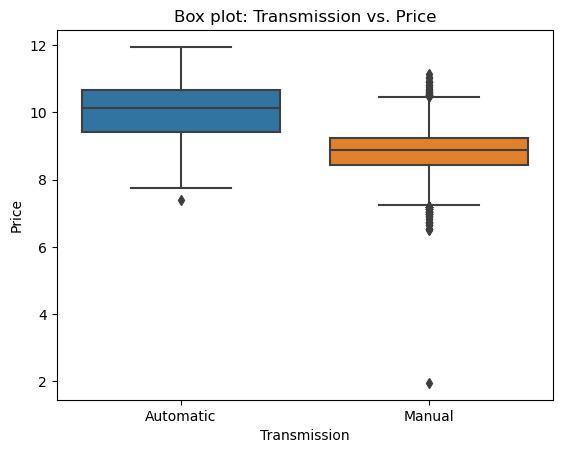

In [723]:
# Year 변수와 price의 상자 그림
sns.boxplot(x=df_raw['Transmission'], y=df_raw['Price'])
plt.xlabel('Transmission')
plt.ylabel('Price')
plt.title('Box plot: Transmission vs. Price')
plt.show()

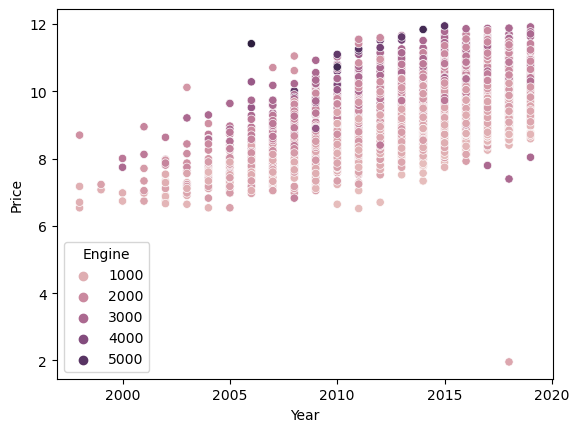

In [726]:
sns.scatterplot(x="Year",y="Price", hue = "Engine",data= df_raw)
plt.show()

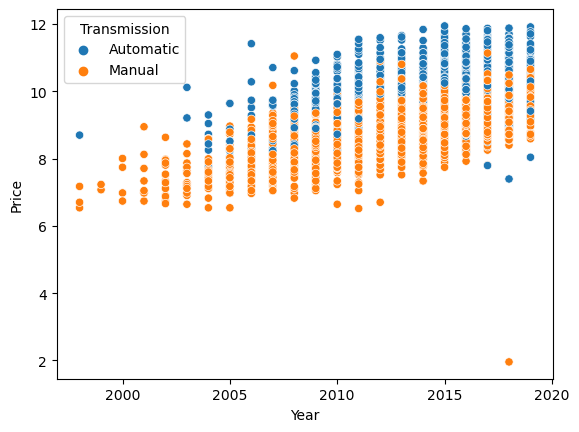

In [727]:
sns.scatterplot(x="Year",y="Price", hue = "Transmission",data= df_raw)
plt.show()

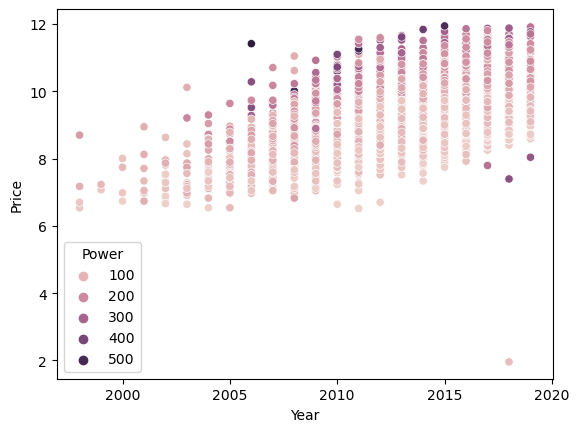

In [728]:
sns.scatterplot(x="Year",y="Price", hue = "Power",data= df_raw)
plt.show()

<Axes: title={'center': 'the price of the year by the transmission'}, xlabel='Year', ylabel='Price'>

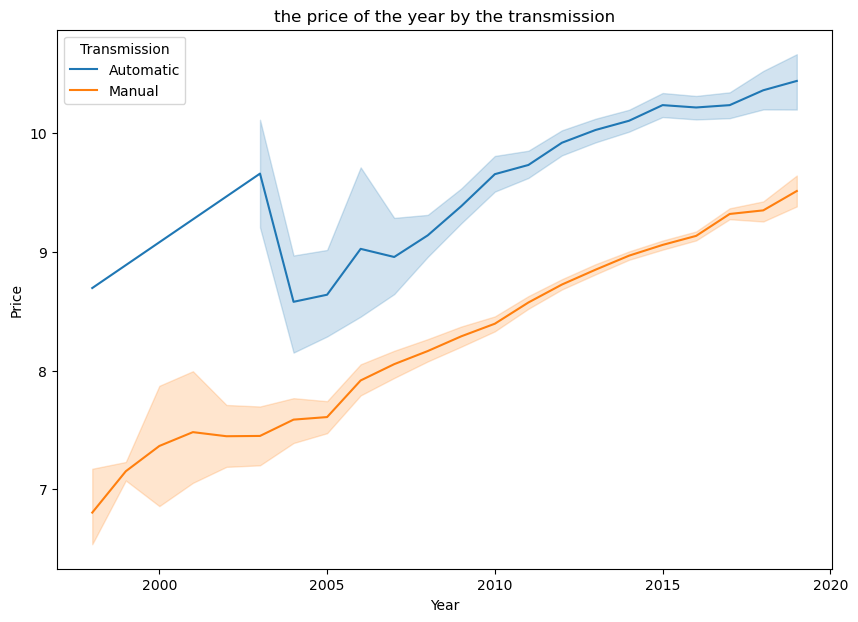

In [581]:
plt.figure(figsize=(10,7))
plt.title("the price of the year by the transmission")
sns.lineplot(x="Year",y="Price", hue = "Transmission",data= df_raw)

In [582]:
from scipy import stats

import statsmodels.formula.api as smf

from statsmodels.stats.anova import anova_lm


In [583]:
formula = "Price ~ Transmission + Year + Engine + Power"

lm = smf.ols(formula, df_raw).fit()

print(anova_lm(lm))

                  df       sum_sq      mean_sq             F         PR(>F)
Transmission     1.0  1792.210033  1792.210033  12955.293101   0.000000e+00
Year             1.0   943.037364   943.037364   6816.904954   0.000000e+00
Engine           1.0  1107.445195  1107.445195   8005.354743   0.000000e+00
Power            1.0   131.122728   131.122728    947.842801  8.988235e-194
Residual      6182.0   855.205848     0.138338           NaN            NaN


In [584]:
df_raw.head()

,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,7.894572,2010,11.184421,CNG,Manual,First,26.60,998.0,58.16,5.0
1,9.860684,2015,10.621327,Diesel,Manual,First,19.67,1582.0,126.20,5.0
2,8.839033,2011,10.736397,Petrol,Manual,First,18.20,1199.0,88.70,5.0
3,9.126715,2012,11.373663,Diesel,Manual,First,20.77,1248.0,88.76,7.0
4,10.210778,2013,10.613246,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0


In [585]:
df_dummy = pd.get_dummies(df_raw[["Fuel_Type", "Transmission","Owner_Type"]])
df_dummy.head()

,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,1,0,0,0,0,0,1,1,0,0,0
1,0,1,0,0,0,0,1,1,0,0,0
2,0,0,0,0,1,0,1,1,0,0,0
3,0,1,0,0,0,0,1,1,0,0,0
4,0,1,0,0,0,1,0,0,0,1,0


In [586]:
df_tot = pd.concat([df_raw, df_dummy], axis = 1)
df_tot = df_tot.drop(["Fuel_Type", "Transmission","Owner_Type"], axis = 1)
df_tot

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,7.894572,2010,11.184421,26.60,998.0,58.16,5.0,1,0,0,0,0,0,1,1,0,0,0
1,9.860684,2015,10.621327,19.67,1582.0,126.20,5.0,0,1,0,0,0,0,1,1,0,0,0
2,8.839033,2011,10.736397,18.20,1199.0,88.70,5.0,0,0,0,0,1,0,1,1,0,0,0
3,9.126715,2012,11.373663,20.77,1248.0,88.76,7.0,0,1,0,0,0,0,1,1,0,0,0
4,10.210778,2013,10.613246,15.20,1968.0,140.80,5.0,0,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6182,9.289401,2016,10.631350,27.28,1047.0,69.00,5.0,0,1,0,0,0,0,1,1,0,0,0
6183,9.508571,2017,10.571701,17.00,1497.0,121.36,5.0,0,0,0,0,1,0,1,1,0,0,0
6184,10.234177,2018,8.699515,16.00,1368.0,160.00,5.0,0,0,0,0,1,0,1,1,0,0,0
6185,9.692976,2017,9.970211,24.30,1248.0,88.50,5.0,0,1,0,0,0,0,1,1,0,0,0


# STEP 4. 모델 생성 : Linear Regression

* 데이터 구성

In [587]:
df_tot.rename(columns = {df_tot.columns[15]:'Owner_FourthAbove'}, inplace = True)
df_tot.head()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_FourthAbove,Owner_Type_Second,Owner_Type_Third
0,7.894572,2010,11.184421,26.60,998.0,58.16,5.0,1,0,0,0,0,0,1,1,0,0,0
1,9.860684,2015,10.621327,19.67,1582.0,126.20,5.0,0,1,0,0,0,0,1,1,0,0,0
2,8.839033,2011,10.736397,18.20,1199.0,88.70,5.0,0,0,0,0,1,0,1,1,0,0,0
3,9.126715,2012,11.373663,20.77,1248.0,88.76,7.0,0,1,0,0,0,0,1,1,0,0,0
4,10.210778,2013,10.613246,15.20,1968.0,140.80,5.0,0,1,0,0,0,1,0,0,0,1,0


In [588]:
df_train, df_test = train_test_split(df_tot, test_size = 0.3, random_state = 1234)
print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (4330, 18)
test data size : (1857, 18)


In [589]:
df_train.head(2)

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_FourthAbove,Owner_Type_Second,Owner_Type_Third
1393,8.433568,2010,11.170435,21.10,1248.00000,73.900000,5.000000,0,1,0,0,0,0,1,1,0,0,0
2524,10.219198,2014,11.069104,18.48,1616.57347,112.765214,5.279722,0,1,0,0,0,1,0,1,0,0,0


In [590]:
df_train.columns

Index(['Price', 'Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power',
       'Seats', 'Fuel_Type_CNG', 'Fuel_Type_Diesel', 'Fuel_Type_Electric',
       'Fuel_Type_LPG', 'Fuel_Type_Petrol', 'Transmission_Automatic',
       'Transmission_Manual', 'Owner_Type_First', 'Owner_FourthAbove',
       'Owner_Type_Second', 'Owner_Type_Third'],
      dtype='object')

* 회귀 모델 생성 : 설명변수 전체

In [740]:
formula = "Price ~ Year + Kilometers_Driven + Mileage + Engine + Power\
       + Seats + Fuel_Type_CNG\
       + Fuel_Type_Diesel + Fuel_Type_Electric + Fuel_Type_LPG\
       + Fuel_Type_Petrol + Transmission_Automatic + Transmission_Manual\
       + Owner_Type_First + Owner_FourthAbove + Owner_Type_Second\
       + Owner_Type_Third"

reg_model = smf.ols(formula, data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1845.
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        20:55:27   Log-Likelihood:                -1361.2
No. Observations:                4330   AIC:                             2752.
Df Residuals:                    4315   BIC:                             2848.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -120

In [741]:
df_train_y = df_train["Price"]
df_train_x = df_train.drop(columns=["Price"], axis=1)
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()
df_vif["Variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i) for i in range(df_train_x_const.shape[1])]

# VIF 정렬
df_vif.sort_values(by='VIF',ascending=True).round(2)



,Variable,VIF
0,const,0.00
2,Kilometers_Driven,1.62
1,Year,1.87
6,Seats,1.93
3,Mileage,3.18
5,Power,6.06
4,Engine,8.22
15,Owner_FourthAbove,inf
14,Owner_Type_First,inf
13,Transmission_Manual,inf


* 회귀 모델 생성 : 유의한 설명변수 확인

In [738]:
formula = "Price ~ Year + Kilometers_Driven + Mileage + Engine + Power\
       + Fuel_Type_CNG\
       + Fuel_Type_Diesel + Fuel_Type_Electric + Fuel_Type_LPG\
       + Fuel_Type_Petrol + Transmission_Automatic + Transmission_Manual\
       + Owner_Type_First + Owner_FourthAbove + Owner_Type_Second\
       + Owner_Type_Third"

reg_model = smf.ols(formula, data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1988.
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        20:54:02   Log-Likelihood:                -1361.2
No. Observations:                4330   AIC:                             2750.
Df Residuals:                    4316   BIC:                             2840.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -120

In [739]:
# 목표변수, 설명변수 데이터 지정
df_train_y = df_train["Price"]
df_train_x = df_train.drop(columns = ["Price","Fuel_Type_Diesel","Owner_Type_Second","Owner_FourthAbove"], axis=1)

# statsmodel의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()
df_vif["Variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i) for i in range(df_train_x_const.shape[1])]

df_vif.sort_values(by='VIF',ascending=True).round(2)

,Variable,VIF
0,const,0.00
8,Fuel_Type_Electric,1.01
9,Fuel_Type_LPG,1.01
7,Fuel_Type_CNG,1.03
14,Owner_Type_Third,1.11
13,Owner_Type_First,1.24
2,Kilometers_Driven,1.62
1,Year,1.87
6,Seats,1.93
10,Fuel_Type_Petrol,2.21


In [733]:
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print("train data의 결정계수:", r2_score(df_train["Price"], train_pred))
print("test data의 결정계수:", r2_score(df_test["Price"], test_pred))

train data의 결정계수: 0.8568792403809302
test data의 결정계수: 0.8158822166357252


# STEP 5. 결론 도출(statsmodels 패키지 사용)

In [596]:
df_train_x_const.columns

Index(['const', 'Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power',
       'Seats', 'Fuel_Type_CNG', 'Fuel_Type_Electric', 'Fuel_Type_LPG',
       'Fuel_Type_Petrol', 'Transmission_Automatic', 'Transmission_Manual',
       'Owner_Type_First', 'Owner_Type_Third'],
      dtype='object')

In [597]:
reg_result.params.values[1:]

array([ 1.21550985e-01, -4.73572018e-02, -1.93686514e-02,  1.58703224e-04,
        7.17028318e-03,  5.71775833e-04, -2.44219510e+01, -2.41701585e+01,
       -2.33648582e+01, -2.43199113e+01, -2.45196267e+01, -6.02316070e+01,
       -6.05648987e+01, -3.01549780e+01, -3.00927581e+01, -3.01977477e+01,
       -3.03510219e+01])

In [598]:
df_reg_coef = pd.DataFrame({"Variable": ['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power',
                                         'Seats','Fuel_Type_CNG','Fuel_Type_Diesel', 'Fuel_Type_Electric', 'Fuel_Type_LPG',
                                         'Fuel_Type_Petrol', 'Transmission_Automatic', 'Transmission_Manual',
                                         'Owner_Type_First', 'Owner_FourthAbove', 'Owner_Type_Second',
                                         'Owner_Type_Third',],
                           "Coef": reg_result.params.values[1:]})

In [599]:
df_reg_coef.sort_values("Coef",ascending = False, inplace= True)
df_reg_coef.round(3)

,Variable,Coef
0,Year,0.122
4,Power,0.007
5,Seats,0.001
3,Engine,0.000
2,Mileage,-0.019
1,Kilometers_Driven,-0.047
8,Fuel_Type_Electric,-23.365
7,Fuel_Type_Diesel,-24.170
9,Fuel_Type_LPG,-24.320
6,Fuel_Type_CNG,-24.422


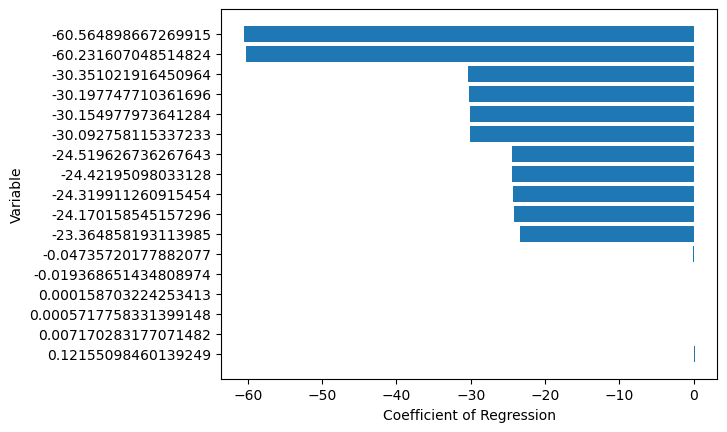

In [600]:
df_reg_coef.sort_values("Coef", ascending=False, inplace = True)
coordinates = range(len(df_reg_coef))
plt.barh(y=coordinates, width = df_reg_coef["Coef"])
plt.yticks(coordinates,df_reg_coef["Coef"])
plt.xlabel("Coefficient of Regression")
plt.ylabel("Variable")
plt.show()

# STEP 4. 모델 생성 : Linear Regression

In [601]:
df_y = df_tot["Price"]
df_x = df_tot.drop("Price", axis=1)

In [602]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3, random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("test data Y size : {}".format(df_train_y.shape))
print("train data X size : {}".format(df_test_x.shape))
print("test data Ysize : {}".format(df_test_y.shape))

train data X size : (4330, 17)
test data Y size : (4330,)
train data X size : (1857, 17)
test data Ysize : (1857,)


In [603]:
lr_model = LinearRegression()
lr_model.fit(df_train_x, df_train_y)

LinearRegression()

In [604]:
df_x.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_FourthAbove,Owner_Type_Second,Owner_Type_Third
0,2010,11.184421,26.60,998.0,58.16,5.0,1,0,0,0,0,0,1,1,0,0,0
1,2015,10.621327,19.67,1582.0,126.20,5.0,0,1,0,0,0,0,1,1,0,0,0
2,2011,10.736397,18.20,1199.0,88.70,5.0,0,0,0,0,1,0,1,1,0,0,0
3,2012,11.373663,20.77,1248.0,88.76,7.0,0,1,0,0,0,0,1,1,0,0,0
4,2013,10.613246,15.20,1968.0,140.80,5.0,0,1,0,0,0,1,0,0,0,1,0


In [605]:
print(lr_model.coef_)

[ 1.21550985e-01 -4.73572018e-02 -1.93686514e-02  1.58703224e-04
  7.17028318e-03  5.71775833e-04 -2.62649837e-01 -1.08574020e-02
  7.94442950e-01 -1.60610118e-01 -3.60325593e-01  1.66645809e-01
 -1.66645809e-01  4.41484553e-02  1.06368314e-01  1.37871859e-03
 -1.51895488e-01]


In [606]:
print(lr_model.intercept_)

-235.55318614579076


In [607]:
df_train_x.columns

Index(['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats',
       'Fuel_Type_CNG', 'Fuel_Type_Diesel', 'Fuel_Type_Electric',
       'Fuel_Type_LPG', 'Fuel_Type_Petrol', 'Transmission_Automatic',
       'Transmission_Manual', 'Owner_Type_First', 'Owner_FourthAbove',
       'Owner_Type_Second', 'Owner_Type_Third'],
      dtype='object')

In [608]:
print("Score on traning set : {:.3f}".format(lr_model.score(df_train_x, df_train_y)))
print("Score on test set : {:.3f}".format(lr_model.score(df_test_x, df_test_y)))

Score on traning set : 0.857
Score on test set : 0.816


In [609]:
# 예측값 생성
train_pred = lr_model.predict(df_train_x)
test_pred = lr_model.predict(df_test_x)

In [610]:
print("train data의 결정계수 : ", r2_score(df_train_y, train_pred))
print("test data의 결정계수 : ", r2_score(df_test_y, test_pred))

train data의 결정계수 :  0.85687924038093
test data의 결정계수 :  0.8158822166357262


In [611]:
print("Prediction for test set : {}".format(test_pred))

Prediction for test set : [9.08756093 8.62912889 9.27588423 ... 8.14038139 8.48933968 9.68577756]


# STEP 5. 결론도출

In [612]:
# 설명변수 중요도(표준화 적용 이전)-> 표준화 회귀계수 산출해야 함
lr_reg_coef = pd.DataFrame({'Coef': lr_model.coef_}, index=df_train_x.columns)

df_reg_coef.sort_values('Coef', ascending=False, inplace=True)
df_reg_coef.round(3)

,Variable,Coef
0,Year,0.122
4,Power,0.007
5,Seats,0.001
3,Engine,0.000
2,Mileage,-0.019
1,Kilometers_Driven,-0.047
8,Fuel_Type_Electric,-23.365
7,Fuel_Type_Diesel,-24.170
9,Fuel_Type_LPG,-24.320
6,Fuel_Type_CNG,-24.422


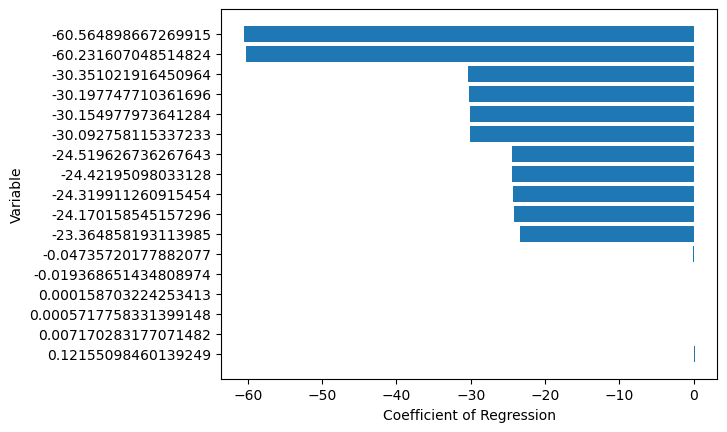

In [613]:
df_reg_coef.sort_values("Coef", ascending=False, inplace = True)
coordinates = range(len(df_reg_coef))
plt.barh(y=coordinates, width = df_reg_coef["Coef"])
plt.yticks(coordinates,df_reg_coef["Coef"])
plt.xlabel("Coefficient of Regression")
plt.ylabel("Variable")
plt.show()

# STEP 4. 모델 생성 : Decision Tree

In [745]:
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV

In [746]:
dt_model = DecisionTreeRegressor()
dt_model.fit(df_train_x, df_train_y)


DecisionTreeRegressor()

In [747]:
train_pred = dt_model.predict(df_train_x)
dt_model.score(df_train_x,df_train_y)

0.9997547830845829

In [748]:
test_pred = dt_model.predict(df_test_x)
dt_model.score(df_test_x,df_test_y)

0.7963857803674603

In [749]:
param_grid = {
    "max_depth": range(2, 10),
    "min_samples_split": range(2, 40, 2),
    "min_samples_leaf": range(2, 20, 2)
}

In [750]:
grid_dt = GridSearchCV(dt_model, param_grid, cv =3 , n_jobs = -1)
grid_dt.fit(df_train_x,df_train_y)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': range(2, 20, 2),
                         'min_samples_split': range(2, 40, 2)})

In [751]:
print("best model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))
print("\nbest set score: \n{}".format(grid_dt.score(df_test_x,df_test_y).round(3)))

best model: 
DecisionTreeRegressor(max_depth=9, min_samples_leaf=16, min_samples_split=32)

best parameter: 
{'max_depth': 9, 'min_samples_leaf': 16, 'min_samples_split': 32}

best score: 
0.853

best set score: 
0.835


In [752]:
tree_final = DecisionTreeRegressor(min_samples_leaf = 16,min_samples_split = 10,max_depth = 9, random_state=1234,)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeRegressor(max_depth=9, min_samples_leaf=16, min_samples_split=10,
                      random_state=1234)

In [753]:
print("Score on training set: {:.3f}".format(tree_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x, df_test_y)))

Score on training set: 0.893
Score on test set: 0.835


In [754]:
df_importance = pd.DataFrame()
df_importance["Feature"] = df_train_x.columns
df_importance["importance"] = tree_final.feature_importances_

df_importance.sort_values("importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,importance
4,Power,0.664
0,Year,0.270
3,Engine,0.043
2,Mileage,0.008
1,Kilometers_Driven,0.006
7,Fuel_Type_Diesel,0.003
11,Transmission_Automatic,0.003
12,Transmission_Manual,0.002
5,Seats,0.001
15,Owner_Type_Second,0.000


Text(0, 0.5, '변수')

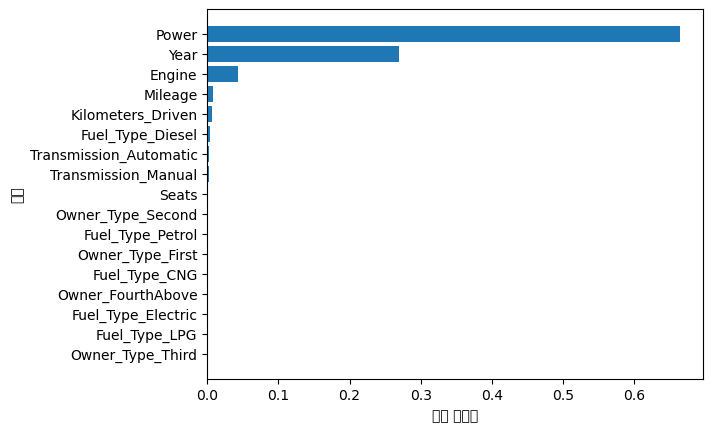

In [755]:
df_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

# Random Forest

In [756]:
from sklearn.ensemble import RandomForestRegressor

In [757]:
rf_model = RandomForestRegressor()
rf_model.fit (df_train_x, df_train_y)

RandomForestRegressor()

In [758]:
train_pred = rf_model.predict(df_train_x)
rf_model.score(df_train_x, df_train_y)

0.9852775916437098

In [759]:
test_pred = rf_model.predict(df_test_x)
rf_model.score(df_test_x, df_test_y)

0.868461462459281

* GridSearchCV를 이용한 최적 parameter/model 찾기

In [760]:
param_grid = {"max_depth" : range(2, 10),
             "min_samples_split" : range(2, 40, 2),
             "min_samples_leaf" : range(2, 20, 2)}

In [761]:
grid_rf = GridSearchCV(rf_model, param_grid, cv=3, n_jobs = -1)
grid_rf.fit(df_train_x, df_train_y)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': range(2, 20, 2),
                         'min_samples_split': range(2, 40, 2)})

In [762]:
print("best model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))
print("\nbest set score: \n{}".format(grid_rf.score(df_test_x,df_test_y).round(3)))

best model: 
RandomForestRegressor(max_depth=9, min_samples_leaf=2)

best parameter: 
{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2}

best score: 
0.891

best set score: 
0.865


* 최종모델

In [763]:
rf_final = RandomForestRegressor(min_samples_leaf = 2, min_samples_split = 4,
                                max_depth = 9, random_state = 1234)
rf_final.fit(df_train_x, df_train_y)

RandomForestRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=4,
                      random_state=1234)

In [764]:
print("Score on training set : {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Score on test set : {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

Score on training set : 0.944
Score on test set : 0.865


In [765]:
df_importance = pd.DataFrame()
df_importance["Feature"] = df_train_x.columns
df_importance["importance"] = rf_final.feature_importances_

df_importance.sort_values("importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,importance
4,Power,0.637
0,Year,0.256
3,Engine,0.051
2,Mileage,0.019
1,Kilometers_Driven,0.017
5,Seats,0.006
12,Transmission_Manual,0.004
11,Transmission_Automatic,0.004
7,Fuel_Type_Diesel,0.002
10,Fuel_Type_Petrol,0.002


Text(0, 0.5, '변수')

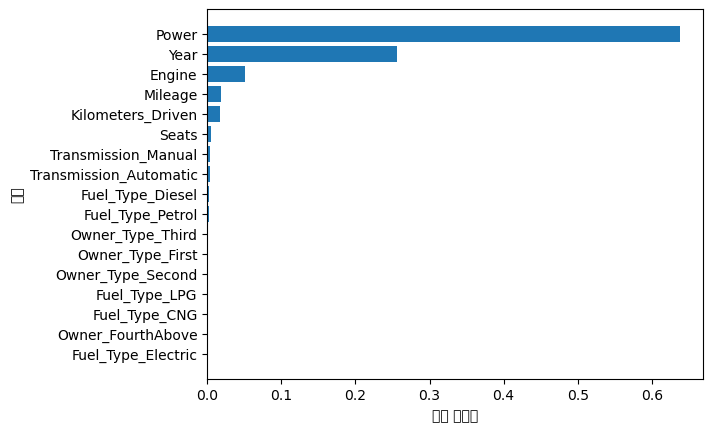

In [766]:
df_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

# 그레디언트

In [767]:
from sklearn.ensemble import GradientBoostingRegressor

In [768]:
gb_model = GradientBoostingRegressor()
gb_model.fit (df_train_x, df_train_y)

GradientBoostingRegressor()

In [769]:
train_pred = gb_model.predict(df_train_x)
gb_model.score(df_train_x, df_train_y)

0.9161344607682651

In [770]:
test_pred = gb_model.predict(df_test_x)
gb_model.score(df_test_x, df_test_y)

0.8536440100611297

In [771]:
param_grid = {"max_depth" : range(2, 10),
             "min_samples_split" : range(2, 40, 2),
             "min_samples_leaf" : range(2, 20, 2)}

In [772]:
grid_gb = GridSearchCV(gb_model, param_grid, cv=3, n_jobs = -1)
grid_gb.fit(df_train_x, df_train_y)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': range(2, 20, 2),
                         'min_samples_split': range(2, 40, 2)})

In [773]:
print("best model: \n{}".format(grid_gb.best_estimator_))
print("\nbest parameter: \n{}".format(grid_gb.best_params_))
print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))
print("\nbest set score: \n{}".format(grid_gb.score(df_test_x,df_test_y).round(3)))

best model: 
GradientBoostingRegressor(max_depth=7, min_samples_leaf=4, min_samples_split=32)

best parameter: 
{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 32}

best score: 
0.902

best set score: 
0.873


In [774]:
gb_final = GradientBoostingRegressor(min_samples_leaf = 4, min_samples_split = 32,
                                max_depth = 7, random_state = 1234)
gb_final.fit(df_train_x, df_train_y)

GradientBoostingRegressor(max_depth=7, min_samples_leaf=4, min_samples_split=32,
                          random_state=1234)

In [775]:
print("Score on training set : {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Score on test set : {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set : 0.962
Score on test set : 0.873


In [776]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame(0)
df_importance["Feature"] = df_train_x.columns
df_importance["importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,importance
4,Power,0.637
0,Year,0.256
3,Engine,0.051
2,Mileage,0.019
1,Kilometers_Driven,0.017
5,Seats,0.006
12,Transmission_Manual,0.004
11,Transmission_Automatic,0.004
7,Fuel_Type_Diesel,0.002
10,Fuel_Type_Petrol,0.002


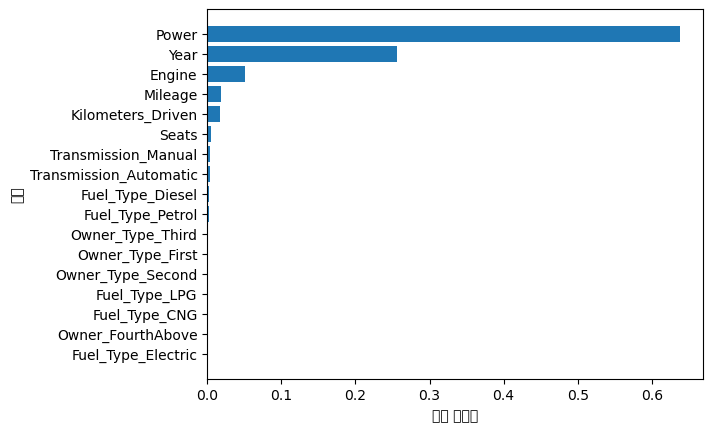

In [777]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.show()

# STEP 6. 예측 모델 평가

In [778]:
# 평가함수 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
# from statsmodels.tools.eval_measures import rmse

In [779]:
# RMSE : root mean squared error 함수
def root_mean_squared_error (df_test_y, lr_y_pred):
    return np.sqrt(mean_squared_error(df_test_y, lr_y_pred))

In [780]:
df_tot.shape

(6187, 18)

In [781]:
# 목표변수, 설명변수 데이터 지정
df_tot_y = df_tot["Price"]
df_tot_x = df_tot.drop("Price", axis = 1, inplace = False)

In [782]:
# train_test_split( X : 설명변수 데이터, Y : 목표변수 데이터)
# test_size = test 데이버 비율, random_state : random seed
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_tot_x, df_tot_y,
                                                                test_size = 0.3, random_state = 1234)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_x.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_x.shape))

train data X size : (4330, 17)
train data Y size : (4330, 17)
test data X size : (1857, 17)
test data Y size : (1857, 17)


예측모델 생성

In [783]:
# 회귀 모델
lr_model = LinearRegression()
lr_model.fit(df_train_x, df_train_y)

LinearRegression()

In [784]:
LinearRegression()

LinearRegression()

In [785]:
# Decision Tree
dt_model = DecisionTreeRegressor(min_samples_leaf = 6, min_samples_split = 16,
                                max_depth = 9, random_state = 1234)
dt_model.fit(df_train_x, df_train_y)

# Random Forest
rf_model = RandomForestRegressor(min_samples_leaf = 6, min_samples_split = 8,
                                max_depth = 9, random_state = 1234)
rf_model.fit(df_train_x, df_train_y)

# Gradient Boosting
gb_model = GradientBoostingRegressor(min_samples_leaf = 6, min_samples_split = 8,
                                max_depth = 9, random_state = 1234)
gb_model.fit(df_train_x, df_train_y)

GradientBoostingRegressor(max_depth=9, min_samples_leaf=6, min_samples_split=8,
                          random_state=1234)

예측 및 평가 

In [786]:
# 모델 리스트, 그래프를 그리기 위한 생성 목적 
models = ["Regression", "Decision Tree", "Random Forest", "Gradient Boosting"]

# 평가 리스트 초기화 
mse, rmse, mae, mape = [], [], [], []

In [787]:
# 1) Regrssion 

# 예측
lr_y_pred = lr_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, lr_y_pred))
rmse.append(root_mean_squared_error(df_test_y, lr_y_pred))
mae.append(mean_absolute_error(df_test_y, lr_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, lr_y_pred))

In [788]:
# 2) Decision Tree

# 예측
df_y_pred = dt_model.predict(df_test_x)

# 평가 
mse.append(mean_squared_error(df_test_y, df_y_pred))
rmse.append(root_mean_squared_error(df_test_y, df_y_pred))
mae.append(mean_absolute_error(df_test_y, df_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, df_y_pred))

In [789]:
# 3) Random Forest

# 예측
rf_y_pred = rf_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y, rf_y_pred))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, rf_y_pred))

In [790]:
# 4) Gradient Boosting

# 예측
gb_y_pred = gb_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y, gb_y_pred))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

시각화 : 평가 

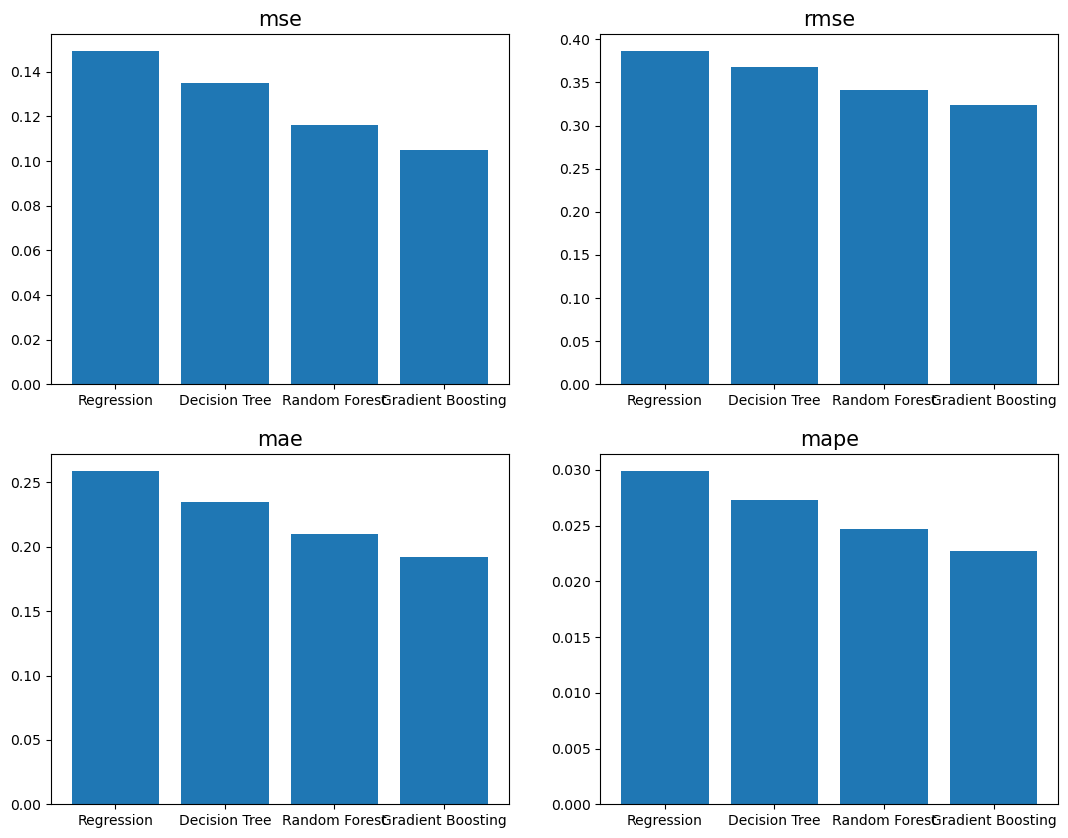

In [791]:
fig, ax = plt.subplots(2,2, figsize = (13, 10))
ax[0,0].bar(models, mse)
ax[0,0].set_title("mse").set_fontsize(15)

ax[0,1].bar(models, rmse)
ax[0,1].set_title("rmse").set_fontsize(15)

ax[1,0].bar(models, mae)
ax[1,0].set_title("mae").set_fontsize(15)

ax[1,1].bar(models, mape)
ax[1,1].set_title("mape").set_fontsize(15)

# STEP 7. Best Model 선정

1. 중고차 가격 예측 모델은 Gradient Boosting 모델로 선정
Modeling 후 평가지표(mse, rmse, mae, mape)로 평가결과는 Gradient Boosting이 가장 적게 나타남
Gradient Boosting < Random Forest < Linear Regression < Decision Tree

2. Modeling 후 성능도 Gradient Boosting 모델이 가장 높게 나타남
순서는 Gradient Boosting(training set: 0.972, test set: 0.895), Random Forest(training set: 0.942, test set: 0.877),
Linear Regression(training set: 0.910, test set: 0.870), Decision Tree(training set: 0.919, test set: 0.839)이다.

# STEP 8. 모델 성능향상 방안

중고차 가격 예측 모델 개발 결과물에 대해 부족한 부분과 개선이 필요한 부분 등 검토하여 모델 성능향상방안 정리

1. 목표변수("Price") 결측치에 대해 제거를 하였으나, 대체 방법 추가 검토
2. 설명변수의 분포의 변환 검토
Kilometers_Driven 분포: 우측으로 기울어짐